In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from math import ceil
from tqdm import tqdm
from PIL import Image

from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

from torchvision.transforms import v2

In [2]:
# Set manual seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

#torch.use_deterministic_algorithms(True)

In [3]:
# Constants 
dataset_path = "../Dataset"
models_path  = "../models"
BATCH_SIZE = 128

if torch.cuda.is_available():
  _DEVICE = "cuda"
else:
  _DEVICE = "cpu"

In [4]:
# Helper functions
def count_parameters(NN):
    return sum([p.numel() for p in NN.parameters() if p.requires_grad==True])

def get_one_hot_encoder(labels):
    def ohe(target):
        oh_vec=torch.zeros(len(labels), dtype=torch.float)
        oh_vec[target] = 1.
        return oh_vec
    return ohe

In [5]:
# Dataset loader
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform_denorm = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

dataset_raw = datasets.ImageFolder(f'{dataset_path}/Train', transform=transform_denorm)
dataset = datasets.ImageFolder(f'{dataset_path}/Train', transform=transform, target_transform=get_one_hot_encoder(dataset_raw.classes))

dataset_train, dataset_val = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), 
                                                                      ceil(len(dataset)*0.2)])

# restrict amount of train data to 10% of the original train
dataset_train, _ = torch.utils.data.random_split(dataset_train, [200, 
                                                                len(dataset_train)-200])

dataset_test  = datasets.ImageFolder(f'{dataset_path}/Test', transform=transform)

train_loader = data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = data.DataLoader(dataset_test,  batch_size=BATCH_SIZE, shuffle=True)
val_loader   = data.DataLoader(dataset_val,   batch_size=BATCH_SIZE, shuffle=True)

dataset_raw_val = [dataset_raw[d] for d in dataset_val.indices]
val_raw_loader  = data.DataLoader(dataset_raw_val,  batch_size=BATCH_SIZE, shuffle=True)

augment_transform = transforms.Compose([v2.RandomResizedCrop(224, scale=(0.9, 1)),
                                        v2.RandomAdjustSharpness(1.5, p=0.2),
                                        v2.RandomAutocontrast(p=0.2)])
src = [i for i in dataset_train]*10
augment_train_loader = data.DataLoader([(augment_transform(i), j) for i, j in dataset_train], batch_size=BATCH_SIZE, shuffle=True)

In [6]:
len(dataset_train)

200

In [7]:
trainSteps = len(train_loader.dataset) // BATCH_SIZE
valSteps   = len(val_loader.dataset)  // BATCH_SIZE

In [8]:
# loading icons for signs
img_names = os.listdir(f"{dataset_path}/Vzor")
icons = dict()

for idx, name in enumerate(img_names):
    img_name = f"{dataset_path}/Vzor/{name}"
    image = Image.open(img_name)
    icons[name.split('.')[0]] = image.resize((224,224), Image.LANCZOS)

icons = np.stack([icons[k] for k in dataset.class_to_idx.keys()], axis=0)

In [9]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 7),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(3,3),
    nn.ReLU(),

    nn.Conv2d(32, 64, 5),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(3,3),
    nn.ReLU(),

    nn.Conv2d(64, 64, 5),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(3,3),
    nn.ReLU(),

    nn.Flatten(),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2304, out_features=256*3, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=256*3, out_features=256, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=256, out_features=len(dataset.classes), bias=True)
)

In [10]:
model(dataset[0][0].unsqueeze(0))

tensor([[ 0.8052, -0.2589,  0.2040, -0.4818, -0.0089, -0.0088, -0.3475, -0.2159,
          0.3413, -0.6059, -0.1020, -0.1428]], grad_fn=<AddmmBackward0>)

In [10]:
print(f"trainable parameters: {count_parameters(model)}")

trainable parameters: 2128972


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
dataset_train.transform = transform

In [ ]:
N_EPOCH = 200

model.to(_DEVICE)
H = [{"train_loss": [],	  "val_loss": []},
     {"train_loss": [],	  "val_loss": []}]
torch.save(model.state_dict(), f"{models_path}/temp.pt")
for aug, loader in zip([1, 0],[augment_train_loader,train_loader]):
  progress_bar = tqdm(range(0, N_EPOCH))
  model.load_state_dict(torch.load(f"{models_path}/temp.pt", weights_only=True))
  model.eval()
  for epoch in progress_bar:
      totalTrainLoss = 0
      totalValLoss = 0
      model.train()
      for inputs, targets in loader:
          optimizer.zero_grad()
          inputs = inputs.to(_DEVICE)
          outputs = model(inputs)
          targets = targets.to(torch.float32).to(_DEVICE)
          loss = loss_fn(outputs, targets)
          loss.backward()
          optimizer.step()
          totalTrainLoss += loss

      with torch.no_grad():
        model.eval()
        for inputs, targets in val_loader:
          inputs = inputs.to(_DEVICE)
          outputs = model(inputs)
          targets = targets.to(_DEVICE)
          totalValLoss += loss_fn(outputs, targets)

      avgTrainLoss = totalTrainLoss / trainSteps
      avgValLoss   = totalValLoss / valSteps
      H[aug]["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
      H[aug]["val_loss"].append(avgValLoss.cpu().detach().numpy())
      progress_bar.set_description(f"Train loss: {avgTrainLoss:.6f} | Val loss: {avgValLoss:.6f}")

Train loss: 0.155785 | Val loss: 0.895135:  82%|████████▎ | 165/200 [11:37<02:30,  4.30s/it]

In [14]:
import pickle
# Save train history
with open('loss_Aug.pickle', 'wb') as handle:
    pickle.dump(H, handle, protocol=pickle.HIGHEST_PROTOCOL)

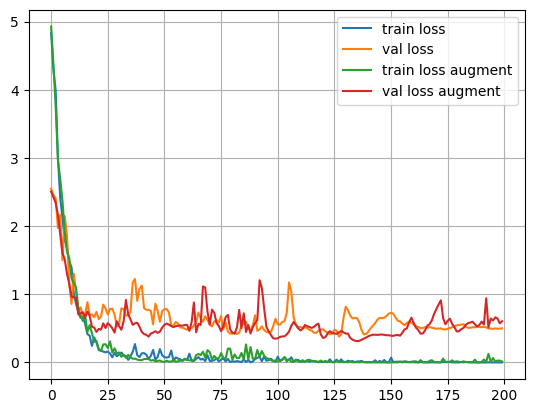

In [13]:
plt.plot(H[0]['train_loss'], label = "train loss")
plt.plot(H[0]['val_loss'], label = "val loss")
plt.plot(H[1]['train_loss'], label = "train loss augment")
plt.plot(H[1]['val_loss'], label = "val loss augment")
plt.legend()
plt.grid()
#plt.yscale('log')
#plt.xscale('log')
plt.show()